In [1]:
import rebound
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from subprocess import call
%matplotlib inline
plt.style.use('paper.mplstyle')

In [2]:
def make_sim(time):
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    
    P1, P2 = 4, 8.02
    m1, m2 = 3e-4, 3e-4
    ecc1, ecc2 = 0.4, 0.21
    p1, p2 = 0, np.pi*1/2

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=m1, P=P1, e=ecc1, pomega=p1, l=np.pi)
    sim.add(m=m2, P=P2, e=ecc2, pomega=p2, l=np.pi)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    times = np.linspace(0,time,1000)
    Pratio = np.zeros(1000)
    for i, t in enumerate(times):
        try:
            sim.integrate(t)
            Pratio[i] = ps[1].P/ps[2].P
        except rebound.Collision:
            print(f"collide at {t}")
            return sim, times, Pratio
    return sim, times, Pratio

Text(0, 0.5, '$P_1/P_2$')

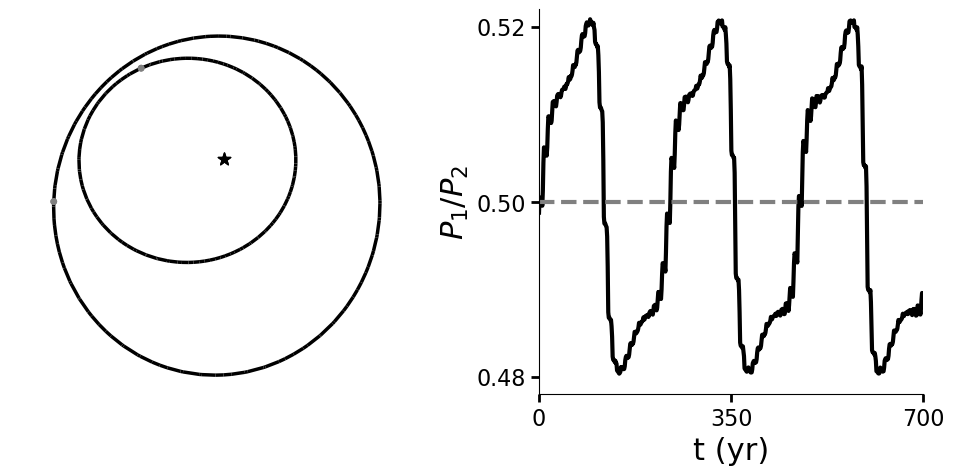

In [3]:
i, t, dpi = 0, 1e3, 0
sim, times, Pratio = make_sim(t)
fig, axarr = plt.subplots(figsize=(12,5), ncols=2, width_ratios=[1.2, 1])
    
ax = axarr[0]
ax.set_aspect("equal")
ax.axis('off')
op = rebound.OrbitPlot(sim, fig=fig, ax=ax, xlim=[-5,5], ylim=[-5.5,3.5], orbit_style="solid",lw=2.5)
op.particles.set_color(["gray","gray"])
op.particles.set_sizes([15,15])

ax = axarr[1]
ax.plot(times,Pratio,color='k')
ax.hlines(1/2,0,t,linestyle='--',color='gray')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([0,350,700])
ax.set_yticks([0.48,0.5,0.52])
ax.set_xlim([0,700])
ax.set_ylim([0.48-0.002,0.52+0.002])
ax.set_xlabel("t (yr)",fontsize=22)
ax.set_ylabel(r"$P_1/P_2$",fontsize=22)

In [4]:
def write_png(params):
    i, t, dpi = params
    sim, times, Pratio = make_sim(t)
    fig, axarr = plt.subplots(figsize=(11,5), ncols=2, width_ratios=[1.2, 1])

    ax = axarr[0]
    ax.set_aspect("equal")
    ax.axis('off')
    op = rebound.OrbitPlot(sim, fig=fig, ax=ax, xlim=[-5,5], ylim=[-5.5,3.5], orbit_style="solid",lw=2.5)
    op.particles.set_color(["gray","gray"])
    op.particles.set_sizes([15,15])

    ax = axarr[1]
    ax.plot(times,Pratio,color='k')
    ax.hlines(1/2,0,700,linestyle='--',color='gray')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks([0,350,700])
    ax.set_yticks([0.48,0.5,0.52])
    ax.set_xlim([0,700])
    ax.set_ylim([0.48-0.002,0.52+0.002])
    ax.set_xlabel("t (yr)",fontsize=22)
    ax.set_ylabel(r"$P_1/P_2$",fontsize=22)
    
    fig.savefig('tmp/{0:0=5d}.png'.format(i), transparent=True, dpi=dpi, bbox_inches='tight')
    plt.close(fig)  

In [ ]:
%%time
dpi = 300.4
Lmovie = 5 # sec
fps = 30
times = np.linspace(0,700, int(Lmovie*fps))

call("rm -f /*.png", shell=True)
pool = rebound.InterruptiblePool()
params = [(i, time, dpi) for i, time in enumerate(times)]
res = pool.map(write_png, params)

In [ ]:
# when you have error code 1: add -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2'
# when you have error code 137: change to smaller figure size
call("ffmpeg -y -framerate 15 -i tmp/%05d.png -pix_fmt yuv420p -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' 2bMMR.mp4", shell=True)